<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/1d_piecewise_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapezoid

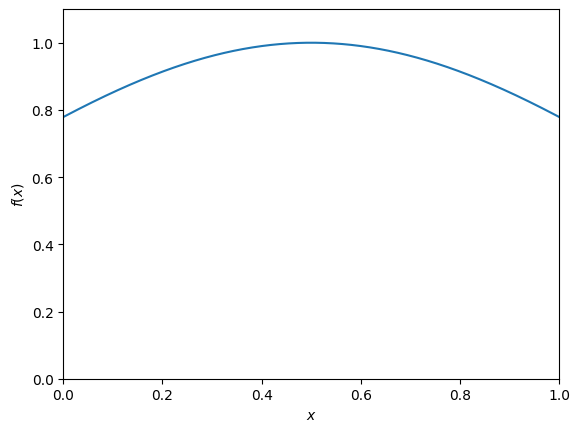

In [ ]:
def f(x):
  return np.exp(-(x-0.5)**2)

xs = np.linspace(0, 1, 1000)
f_evals = f(xs)
plt.plot(xs, f_evals)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.show()

In [ ]:
K = 5    #NUMBER OF BINS

x_bins = np.linspace(0, 1, K+1)   #edges

#y_initial = np.linspace(0, 1, K+1)    #(K+1) heights; (K-1) parameters


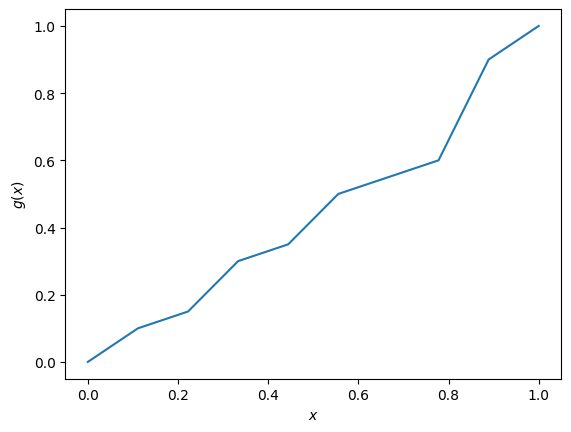

In [ ]:
def g_new(x, y_params):

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = np.linspace(0, 1, K+1)
  ys = np.concatenate(([0.0], y_params, [1.0]))

  #find the correct bin indices i for each x value
  i_values = np.minimum((x*K).astype(int), K-1) # Ensures indices are within the valid range [0, K-1]

  #compute the edges
  x_left = x_bins[i_values]
  x_right = x_bins[i_values + 1]
  y_left = ys[i_values]
  y_right = ys[i_values + 1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

test = g_new(xs, np.array([0.1, 0.15, 0.3, 0.35, 0.5, 0.55, 0.6, 0.9]))
plt.plot(xs, test)
plt.xlabel("$x$")
plt.ylabel("$g(x)$")
plt.show()

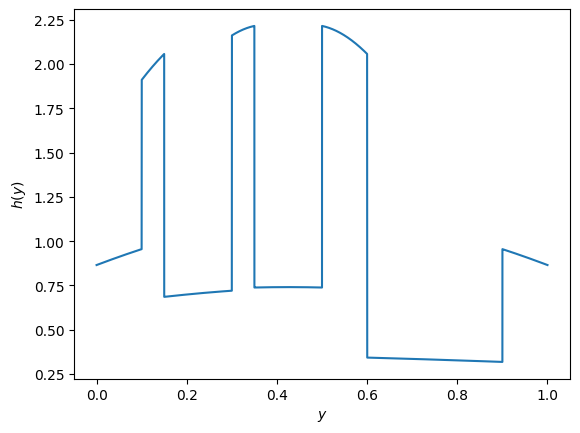

In [ ]:
def transformed_f_new(y, y_params):

  #bins
  K = len(y_params) + 1

  #using given params, append 0 and 1 to the ends
  x_bins = np.linspace(0, 1, K+1)
  ys = np.concatenate(([0.0], y_params, [1.0]))

  #find the correct bin indices i for each y value
  #j_values = np.minimum((np.searchsorted(ys, y) - 1), K - 1)    # Ensures indices are within the valid range [0, K-1]
  j_values = np.searchsorted(ys, y) - 1
  j_values = np.clip(j_values, 0, K-1)
  #ensure exact y==1 map to last bin
  j_values = np.where(y == 1.0, K-1, j_values)
  #compute the edges
  x_left = x_bins[j_values]
  x_right = x_bins[j_values + 1]
  y_left = ys[j_values]
  y_right = ys[j_values + 1]

  def g_inv_new(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv_new(y)
  jac = jacobians(x_left, x_right, y_left, y_right)

  return f(arg) * jac


y_test = np.linspace(1e-10, 1, 10000)
test_params = np.array([0.1, 0.15, 0.3, 0.35, 0.5, 0.55, 0.6, 0.9])
transform_test = transformed_f_new(y_test, test_params)
plt.plot(y_test, transform_test)
plt.xlabel("$y$")
plt.ylabel("$h(y)$")
plt.show()

In [ ]:
#integration preservation checks

x_int_test, y_int_test = np.linspace(0, 1, 10000), np.linspace(0, 1, 1000000)
h_test_params = test_params

f_evals_test = f(x_int_test)
F = trapezoid(f_evals_test, x_int_test)
print("Trapezoid method: F = ", F)
F_q = quad(lambda x: f(x), 0, 1)
print("Quad method: F = ", F_q[0])

H_evals_test = transformed_f_new(y_int_test, h_test_params)
H = trapezoid(H_evals_test, y_int_test)
print("Trapezoid method: H = ", H)
H_q = quad(lambda y: transformed_f_new(y, h_test_params), 0, 1)
print("Quad method: H = ", H_q[0])

Trapezoid method: F =  0.922562011527324
Quad method: F =  0.9225620128255849
Trapezoid method: H =  0.9225618982416148
Quad method: H =  0.9225620154019719


/tmp/ipython-input-1819986058.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  H_q = quad(lambda y: transformed_f_new(y, h_test_params), 0, 1)


In [ ]:
#variance checks - they should be different before optimisation

f_var = np.var(f_evals_test)

h_var = np.var(H_evals_test)

print("Variance of f: ", f_var)
print("Variance of h: ", h_var)

Variance of f:  0.004505340906565452
Variance of h:  0.40628222961039967


In [ ]:
#optimisation

#reparametrise y_params in terms of u using softmax to avoid numerical instability
from scipy.special import softmax

def u_to_y(u):
  w = softmax(np.concatenate((u, [0.0])))
  ys = np.cumsum(w)
  return ys[:-1]

def objective_u(u_params, x):
  y_params = u_to_y(u_params)
  y = g_new(x, y_params)
  return np.var(transformed_f_new(y, y_params))


#obj_test = objective_u(np.array([-1.921e-04, 1.174e-01, 1.564e-01, 1.173e-01]), np.linspace(1e-10, 1, 10000))
#print(obj_test)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.319011781263839e-05
       x: [-1.968e-04  2.888e-02 ...  5.690e-02  2.929e-02]
     nit: 16
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 9.978e-06 -2.443e-04 ... -6.971e-05 -8.488e-05]]
    nfev: 5648
Optimised parameters: [0.02678552 0.05436128 0.08270867 0.11179395 0.14156238 0.17197241
 0.20298612 0.23454905 0.26660692 0.29910994 0.33199343 0.36519707
 0.39866237 0.43232649 0.4661215  0.49998257 0.53384368 0.56763966
 0.60130329 0.63476817 0.66797486 0.70086273 0.73336488 0.76542329
 0.79698705 0.8279996  0.85840965 0.88818204 0.91726269 0.94562218
 0.97320921]


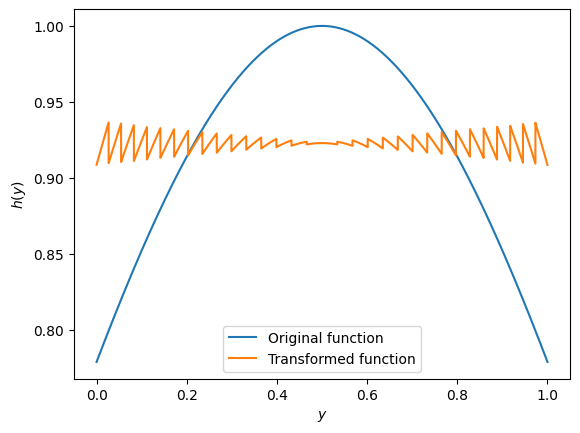

In [ ]:
from scipy.optimize import minimize

#arrays

params0 = np.zeros(31)
x_values = np.random.random(100000)
y_values = np.random.random(100000)

y_vals_to_plot = np.linspace(1e-10, 1, 10000)

#constraints

#bounds

result = minimize(
    objective_u,
    params0,
    args=(x_values),
    method='Powell'
)

opt_params = u_to_y(result.x)
print(result)
print("Optimised parameters:", opt_params)

#plotting

plt.figure()
plt.plot(y_vals_to_plot, f(y_vals_to_plot), label="Original function")
opt_h = transformed_f_new(y_vals_to_plot, opt_params)
#print(opt_h[0:10])
plt.plot(y_vals_to_plot, opt_h, label="Transformed function")
plt.xlabel("$y$")
plt.ylabel("$h(y)$")
plt.legend()
plt.show()

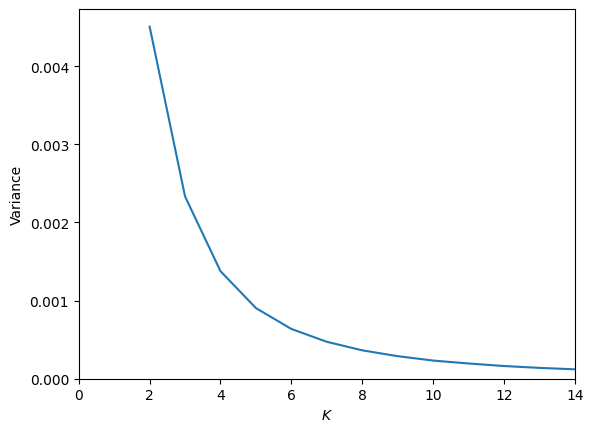

In [ ]:
#variance as a function of K
Ks = range(2, 33)
vars = np.array([])
for K in Ks:
  u0 = np.zeros(K-1)
  x_values = np.random.rand(100000)

  result = minimize(
    objective_u,
    u0,
    args=(x_values),
    method='Powell'
  )

  var = result.fun
  vars = np.append(vars, var)

plt.plot(Ks, vars)
plt.xlabel("$K$")
plt.ylim(0)
plt.ylabel("Variance")
plt.show()

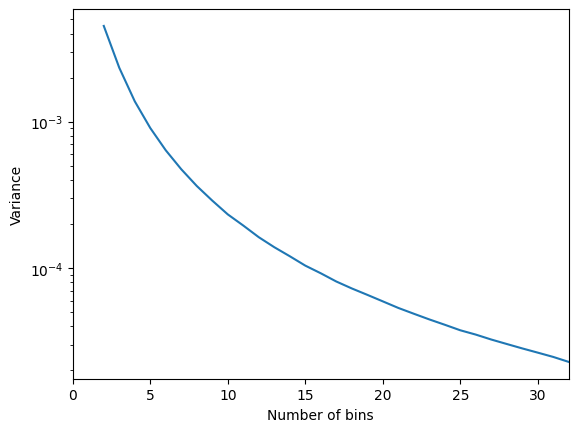

In [22]:
#better plot
plt.plot(Ks, vars)
plt.xlabel("Number of bins")
plt.yscale('log')
plt.xlim(0, 32)
#plt.ylim(0)
plt.ylabel("Variance")
plt.show()

In [ ]:
#understanding how searchsorted works
y_bins = np.array([0.0, 0.1, 0.3, 0.6, 0.9, 1.0])
y = np.array([0.05, 0.2, 0.4, 0.8])
print(np.searchsorted(y_bins, y))


[1 2 3 4]
